In [1]:
from iris import time, cube
import cis
from cis import read_data, read_data_list, get_variables, data_io
from cis.data_io import gridded_data
from cis.data_io.gridded_data import make_from_cube
from cis.time_util import PartialDateTime
from cis import plotting
from cis.plotting import plot
from cis.plotting.plot import drawbluemarble, multilayer_plot, taylor_plot

import os
from datetime import datetime
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import copy
from flight_py_tools import FAAM

from dateutil.relativedelta import relativedelta
import numpy as np
import numpy.ma as ma
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)


In [2]:
# Directory containing raw aircraft data and names of variables to plot
inputdir1='/scratch/am2688/netscratch_all/mrr32/Flight_work/Flights/'
varname1='O3_TECO' ; source1='FAAM' ; variable1='Ozone' ; units1='(ppbv)'
# Position of date characters in the filename string
# Plugin to be used by cis.read_data
aircraft_plugin='FAAM'
# Directory containing model data on flight track and names of variables to plot
inputdir2='/scratch/am2688/netscratch_all/mrr32/Flight_work/Outdir/'
inputdir3='/scratch/am2688/netscratch_all/mrr32/Flight_work/Outdir_75/'
inputdir4='/scratch/am2688/netscratch_all/mrr32/Flight_work/Outdir_50/'
inputdir5='/scratch/am2688/netscratch_all/mrr32/Flight_work/Outdir_25/'

varname2='m01s51i001' ; source2='UKCA' ; variable2='Ozone' ; units2='(ppbv)'
stash='51001' ; cfactor=1.e9/1.657
# Directory to store plots
outdir='/home/am2688/nethome/Plots/'
# colors for colorbars (from https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3):
# Diverging: blue to red (9 colours)
blue_to_red =['#313695','#4575b4','#74add1','#abd9e9','#ffffff','#fdae61','#f46d43','#d73027','#a50026'] 
# Diverging: green to magenta (9 colours)
green_to_magenta = ['#276419','#4d9221','#7fbc41','#b8e186','#ffffff','#f1b6da','#de77ae','#c51b7d','#8e0152']
# Sequential: yellow to red (7 colours)
yellow_to_red = ['#ffffb2','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#b10026']
my_colours= ['#a6cee3','#1f78b4','#b2df8a','#33a02c'] #colourblind+qualitative safe, but included greens
final_colours= ['#ca0020','#f4a582','#92c5de','#0571b0'] #colourblind safe + diverging
colour_100='#ca0020'
colour_75='#f4a582'
colour_50='#0571b0'
colour_25='#92c5de'

In [3]:
# Read all Obs
infile1=inputdir1+'*.nc'
obs=cis.read_data(infile1,varname1,product='FAAM')
# Read all Model data 100%
infile2=inputdir2+'*'+'stash'+stash+'*'
mod=cis.read_data(infile2,varname2,product='FAAM')


In [4]:
# Extract np arrays from variables masked arrays
# This is necessary to avoid errors whilst operating on the variables
obs.data=ma.getdata(obs.data)
mod.data=ma.getdata(mod.data)
for cc in range(len(obs._coords)) :
    obs._coords[cc].data=ma.getdata(obs._coords[cc].data)
    mod._coords[cc].data=ma.getdata(mod._coords[cc].data)

In [5]:
#remove negative and nans using masked arrays
obs.data=ma.masked_less_equal(obs.data, 3)
obs.data=ma.masked_invalid(obs.data)
#obs.data=ma.masked_greater_equal(obs.data, 90)
# Convert model data to ppbv
mod.data=mod.data*cfactor
mod.data=ma.masked_invalid(mod.data)
# Subset Model and Obs
# Tropical Upper Troposphere (TUT): 6-13km and 30S:30N
TUT_obs=obs.subset(z=[6000.,13000.],y=[-30.,30.])
TUT_mod=mod.subset(z=[6000.,13000.],y=[-30.,30.])

# Mid-latitude Upper Troposphere/Lower Stratosphere: 6-13km and 30N:90N
UTLS_obs=obs.subset(z=[6000.,13000.],y=[30.,90.])
UTLS_mod=mod.subset(z=[6000.,13000.],y=[30.,90.])

# Boundary layer (BL): 0-1km
NHLT_obs=obs.subset(z=[0.,6000.],y=[30.,90.])
NHLT_mod=mod.subset(z=[0.,6000.],y=[30.,90.])

# Lower Troposphere (LT): 0-6km
TLT_obs=obs.subset(z=[0.,6000.], y=[-30.,30.])
TLT_mod=mod.subset(z=[0.,6000.],y=[-30.,30.])

In [6]:
points_TUT=len(TUT_obs.data)
print(len(TUT_mod.data))
print(len(UTLS_obs.data))
print(len(UTLS_mod.data))
print(len(TLT_obs.data))
print(len(TLT_mod.data))

688466
1733521
1733521
1818742
1818742


In [7]:
points_TUT=str(len(TUT_obs.data))
points_UTLS=str(len(UTLS_obs.data))
points_TLT=str(len(TLT_obs.data))
points_NHLT=str(len(NHLT_obs.data))

In [8]:
type(points_TUT)

str

In [9]:
N_points_TUT='# points='+points_TUT
N_points_UTLS='# points='+points_UTLS
N_points_TLT='# points='+points_TLT
N_points_NHLT='# points='+points_NHLT
print(N_points_TUT)

# points=688466


In [10]:

#Correlation for TUT
mod_o3 = TUT_mod.data
obs_o3 = TUT_obs.data

#mask first
mod_masked=np.ma.masked_array(mod_o3, [np.isnan(x) for x in mod_o3])
obs_masked=np.ma.masked_array(obs_o3, [np.isnan(x) for x in obs_o3])
slope,intercept=np.ma.polyfit(mod_masked, obs_masked, 1)
print(slope, intercept)


import scipy
slope, intercept, Pearson_r, p_value, std_err = scipy.stats.mstats.linregress(mod_masked, obs_masked)
print(slope,intercept,Pearson_r,p_value,std_err)
                                                          

0.7047702618708721 11.233683952763474
0.7047702618708773 11.233683595361711 0.5817899384225961 0.0 0.0012142886862299047


In [11]:
gradient=np.array2string(np.around(slope,3))
type(gradient)
r_squared=np.array2string(np.around(Pearson_r,2))
thing='slope='+gradient
pearson='R$^{2}$='+r_squared
print(gradient)

0.705


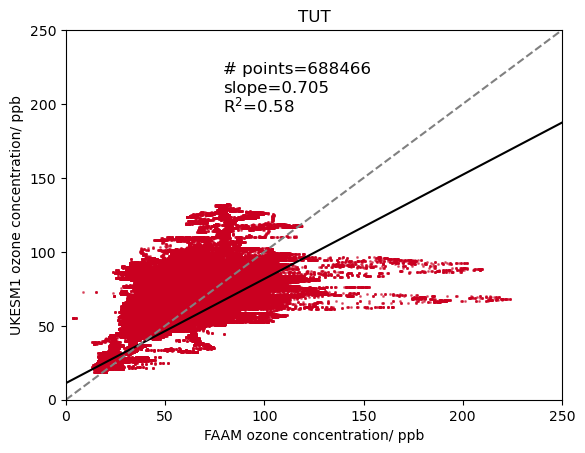

In [12]:
fig, ax = plt.subplots()
plt.scatter(TUT_obs.data, TUT_mod.data, c= colour_100, marker='.', s=5,alpha=0.5)
ax.axline((0, intercept), slope=slope, c='black')
ax.axline((0, 0), slope=1, c='grey', linestyle='--')
plt.ylim([0,250])
plt.xlim([0,250])
plt.xlabel('FAAM ozone concentration/ ppb')
plt.ylabel('UKESM1 ozone concentration/ ppb')
plt.title('TUT')

plt.figtext(0.37, 0.75, thing, c='black', fontsize=12) 
plt.figtext(0.37, 0.71, pearson, c='black', fontsize=12) 
plt.figtext(0.37, 0.79, N_points_TUT, c='black', fontsize=12) 
#plt.show()
plt.savefig(outdir+'scatter_tut_100.png',dpi=300,bbox_inches='tight')
plt.show()

In [10]:

#Correlation for TUT
mod_o3 = TLT_mod.data
obs_o3 = TLT_obs.data

#mask first
mod_masked=np.ma.masked_array(mod_o3, [np.isnan(x) for x in mod_o3])
obs_masked=np.ma.masked_array(obs_o3, [np.isnan(x) for x in obs_o3])
slope,intercept=np.ma.polyfit(mod_masked, obs_masked, 1)
print(slope, intercept)


import scipy
slope, intercept, Pearson_r, p_value, std_err = scipy.stats.mstats.linregress(mod_masked, obs_masked)
print(slope,intercept,Pearson_r,p_value,std_err)
                                                          

0.7924659290051176 2.3006792597389207
0.7924659290051219 2.3006795249608345 0.7445905110834741 0.0 0.0006720612852007783


In [11]:
gradient=np.array2string(np.around(slope,3))
type(gradient)
r_squared=np.array2string(np.around(Pearson_r,2))
thing='slope='+gradient
pearson='R$^{2}$='+r_squared
print(gradient)

0.792


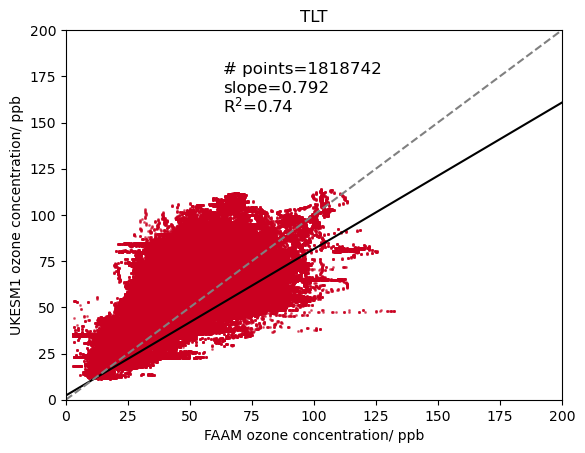

In [12]:
fig, ax = plt.subplots()
plt.scatter(TLT_obs.data, TLT_mod.data, c= colour_100, marker='.', s=5,alpha=0.5)
plt.ylim([0,200])
plt.xlim([0,200])
plt.xlabel('FAAM ozone concentration/ ppb')
plt.ylabel('UKESM1 ozone concentration/ ppb')
plt.title('TLT')

ax.axline((0, intercept), slope=slope, c='black')
ax.axline((0, 0), slope=1, c='grey', linestyle='--')

plt.figtext(0.37, 0.75, thing, c='black', fontsize=12) 
plt.figtext(0.37, 0.71, pearson, c='black', fontsize=12) 
plt.figtext(0.37, 0.79, N_points_TLT, c='black', fontsize=12)
#plt.show()
plt.savefig(outdir+'scatter0_6000_TLT_100.png',dpi=300,bbox_inches='tight')

In [17]:

#Correlation for TUT
mod_o3 = UTLS_mod.data
obs_o3 = UTLS_obs.data

#mask first
mod_masked=np.ma.masked_array(mod_o3, [np.isnan(x) for x in mod_o3])
obs_masked=np.ma.masked_array(obs_o3, [np.isnan(x) for x in obs_o3])
slope,intercept=np.ma.polyfit(mod_masked, obs_masked, 1)
print(slope, intercept)


import scipy
slope, intercept, Pearson_r, p_value, std_err = scipy.stats.mstats.linregress(mod_masked, obs_masked)
print(slope,intercept,Pearson_r,p_value,std_err)
                                                          

1.0923172393842544 -11.443605110153891
1.092317239384255 -11.44361056671032 0.6512406142419556 0.0 0.000982626910553063


In [18]:
gradient=np.array2string(np.around(slope,3))
type(gradient)
r_squared=np.array2string(np.around(Pearson_r,2))
thing='slope='+gradient
pearson='R$^{2}$='+r_squared
print(gradient)

1.092


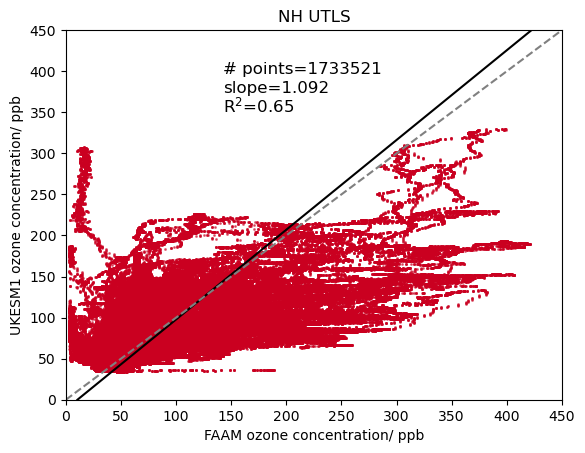

In [19]:
fig, ax = plt.subplots()
plt.scatter(UTLS_obs.data, UTLS_mod.data, c= colour_100, marker='.', s=5,alpha=0.5)
plt.ylim([0,450])
plt.xlim([0,450])
plt.xlabel('FAAM ozone concentration/ ppb')
plt.ylabel('UKESM1 ozone concentration/ ppb')
plt.title('NH UTLS')

ax.axline((0, intercept), slope=slope, c='black')
ax.axline((0, 0), slope=1, c='grey', linestyle='--')

plt.figtext(0.37, 0.75, thing, c='black', fontsize=12) 
plt.figtext(0.37, 0.71, pearson, c='black', fontsize=12)
plt.figtext(0.37, 0.79, N_points_UTLS, c='black', fontsize=12)
#plt.show()
plt.savefig(outdir+'scatter_UTLS_100.png',dpi=300,bbox_inches='tight')

In [13]:

#Correlation for TUT
mod_o3 = NHLT_mod.data
obs_o3 = NHLT_obs.data

#mask first
mod_masked=np.ma.masked_array(mod_o3, [np.isnan(x) for x in mod_o3])
obs_masked=np.ma.masked_array(obs_o3, [np.isnan(x) for x in obs_o3])
slope,intercept=np.ma.polyfit(mod_masked, obs_masked, 1)
print(slope, intercept)


import scipy
slope, intercept, Pearson_r, p_value, std_err = scipy.stats.mstats.linregress(mod_masked, obs_masked)
print(slope,intercept,Pearson_r,p_value,std_err)
                                                          

0.6599791149220181 16.445701921851306
0.6599791149220201 16.445703702874592 0.5604105536373838 0.0 0.0005069138334423946


In [14]:
gradient=np.array2string(np.around(slope,3))
type(gradient)
r_squared=np.array2string(np.around(Pearson_r,2))
thing='slope='+gradient
pearson='R$^{2}$='+r_squared #as r squared was 0.6 but need 2dp
#pearson='R$^{2}$=0.60'
print(gradient)


0.66


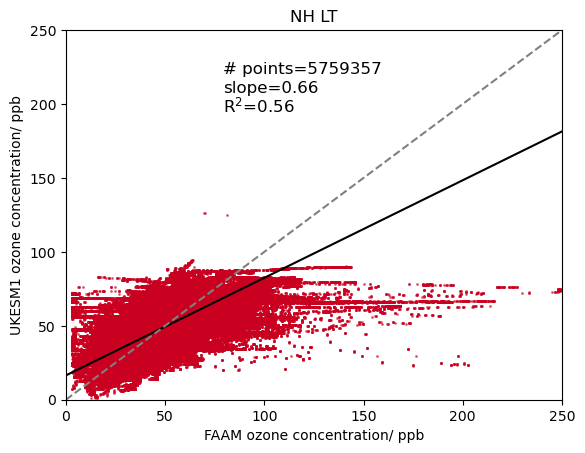

In [15]:
fig, ax = plt.subplots()
plt.scatter(NHLT_obs.data, NHLT_mod.data, c= colour_100, marker='.', s=5,alpha=0.5)
plt.ylim([0,250])
plt.xlim([0,250])
plt.xlabel('FAAM ozone concentration/ ppb')
plt.ylabel('UKESM1 ozone concentration/ ppb')
plt.title('NH LT')

ax.axline((0, intercept), slope=slope, c='black')
ax.axline((0, 0), slope=1, c='grey', linestyle='--')

plt.figtext(0.37, 0.75, thing, c='black', fontsize=12) 
plt.figtext(0.37, 0.71, pearson, c='black', fontsize=12)
plt.figtext(0.37, 0.79, N_points_NHLT, c='black', fontsize=12)
#plt.show()
plt.savefig(outdir+'scatter0_6000_NHLT_100.png',dpi=300,bbox_inches='tight')